### initialization


In [ ]:
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor


game = gym.make('MsPacman-v0')

csv = pd.read_csv('/home/brent/tmp/dqn_10M.csv')
xticks = (np.arange(0, 1.1e7, 1e6), ['{0}M'.format(x) for x in range(0, 11)])
rewards = csv['reward'] * 10
losses = csv['loss']
mean_qs = csv['mean_q']
plt.rcParams["figure.figsize"] = [16, 9]


### agent model

In [ ]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        return (np
                .dot(observation, [.2989, .5870, .1140]) # greyscale
                [5:165:2, ::2]                              # clip+downsample
                .astype('uint8'))                           # optimize

    def process_state_batch(self, batch):
        return batch.astype('float32') / 255.

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


### architecture

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape=(4, 80, 80), 
                 data_format='channels_first',
                 filters=16, 
                 kernel_size=(8, 8), 
                 strides=4,
                 activation='relu'))

model.add(Conv2D(filters=32, 
                 kernel_size=(4, 4), 
                 strides=2,
                 activation='relu'))

model.add(Flatten())

model.add(Dense(units=256,
                activation='relu'))

model.add(Dense(units=game.action_space.n, 
                activation='linear'))

model.summary()


### training

In [ ]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps', 
                              value_max=1., 
                              value_min=.1, 
                              value_test=.05,
                              nb_steps=1000000)

dqn = DQNAgent(model=model, 
               nb_actions=game.action_space.n, 
               policy=policy, 
               memory=SequentialMemory(limit=1000000, window_length=4),
               processor=AtariProcessor(), 
               nb_steps_warmup=50000, 
               gamma=.99, 
               train_interval=4, 
               delta_clip=1.,
               enable_double_dqn=False)

dqn.compile(optimizer='rmsprop', metrics=['mae'])

dqn.fit(game, nb_steps=10000000, log_interval=10000)

dqn.save_weights('dqn_weights.h5f', overwrite=True)


### performance

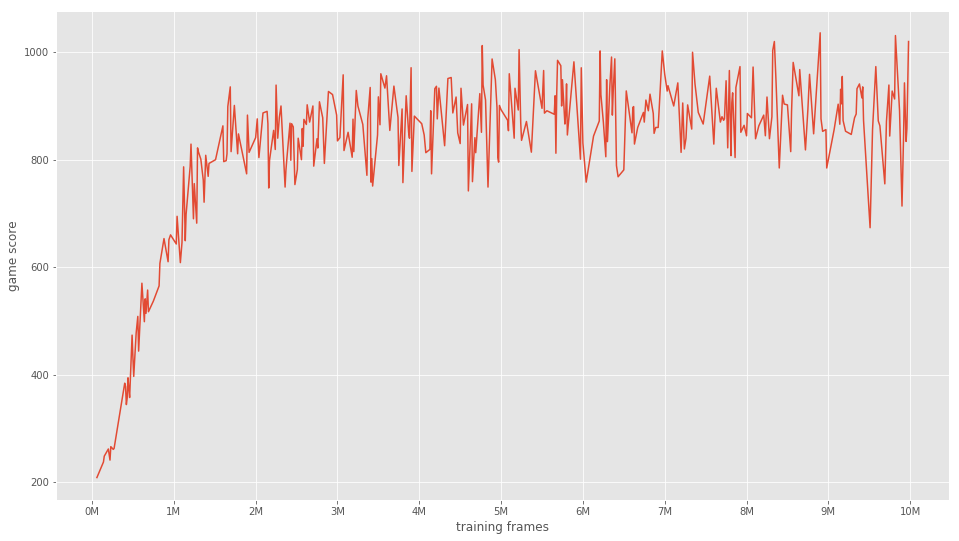

In [6]:
plt.plot(csv['frames'], rewards)
plt.xlabel('training frames')
plt.xticks(*xticks)
plt.ylabel('game score')
plt.show()


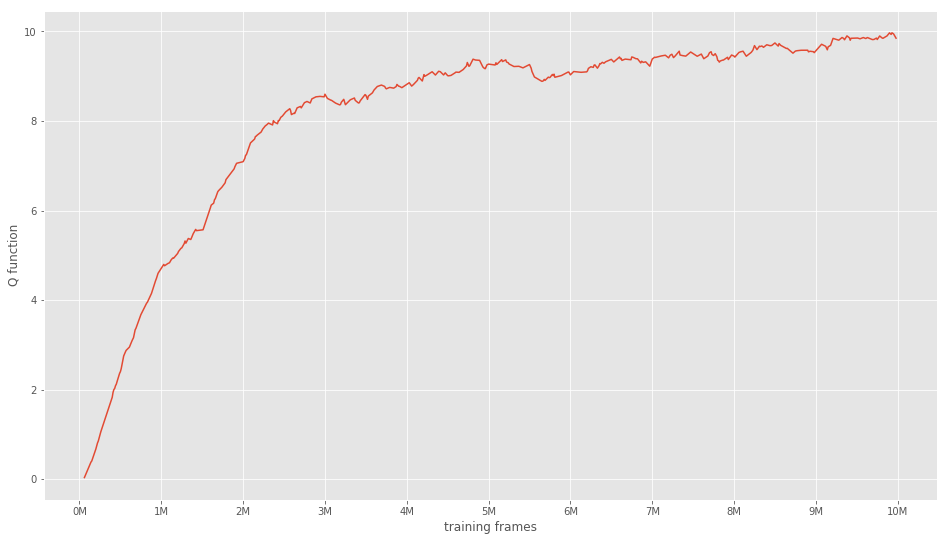

In [7]:
plt.plot(csv['frames'], mean_qs)
plt.xlabel('training frames')
plt.xticks(*xticks)
plt.ylabel('Q function')
plt.show()
